# 0.0. IMPORTS

In [29]:
import pandas as pd
import math
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from IPython.display import Image

## 0.1. Helper Functions

## 0.2. Data Loading

In [2]:
file_sales = '../data/train.csv'
file_store = '../data/store.csv'

In [3]:
df_sales_raw = pd.read_csv(file_sales, low_memory=False)
df_store_raw = pd.read_csv(file_store, low_memory=False)

In [4]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
559897,953,6,2014-02-15,2477,249,1,0,0,0,a,a,19830.0,4.0,2006.0,1,22.0,2011.0,"Mar,Jun,Sept,Dec"


# 1.0. DATA DESCRIPTION

## 1.1. Rename Columns

In [5]:
df = df_raw.copy()

In [6]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = df.columns
f_snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(f_snakecase, cols_old))
df.columns = cols_new
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [8]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of cols: {df.shape[1]}")

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [9]:
df.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. NA Check

In [12]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [13]:
df1 = df.copy()

In [14]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(lambda x:
                                                                                          x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                                          else x['competition_open_since_month'],
                                                                                          axis=1
                                                                                         )

#competition_open_since_year
df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(lambda x:
                                                                                        x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                                        else x['competition_open_since_year'],
                                                                                        axis=1
                                                                                       )

#promo2_since_week
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x:
                                                                    x['date'].week if math.isnan(x['promo2_since_week'])
                                                                    else x['promo2_since_week'],
                                                                    axis=1
                                                                   )

#promo2_since_year
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x:
                                                                    x['date'].year if math.isnan(x['promo2_since_year'])
                                                                    else x['promo2_since_year'],
                                                                    axis=1
                                                                   )

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x:
                                                            0 if x['promo_interval'] == 0
                                                            else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                            else 0,
                                                            axis=1
                                                            )


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [20]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
dp1 = pd.DataFrame(num_attributes.apply(np.std)).T
dp2 = pd.DataFrame(num_attributes.apply(min)).T
dp3 = pd.DataFrame(num_attributes.apply(max)).T
dp4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dp5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dp6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([dp2, dp3, dp4, ct1, ct2, dp1, dp5, dp6]).T.reset_index()
m.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


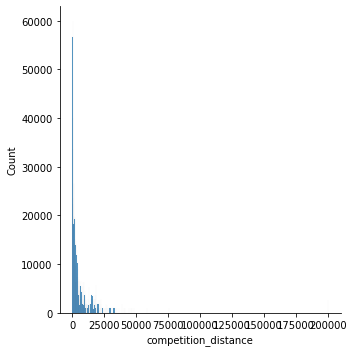

In [21]:
sns.displot(df1['competition_distance'])

### 1.7.2. Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

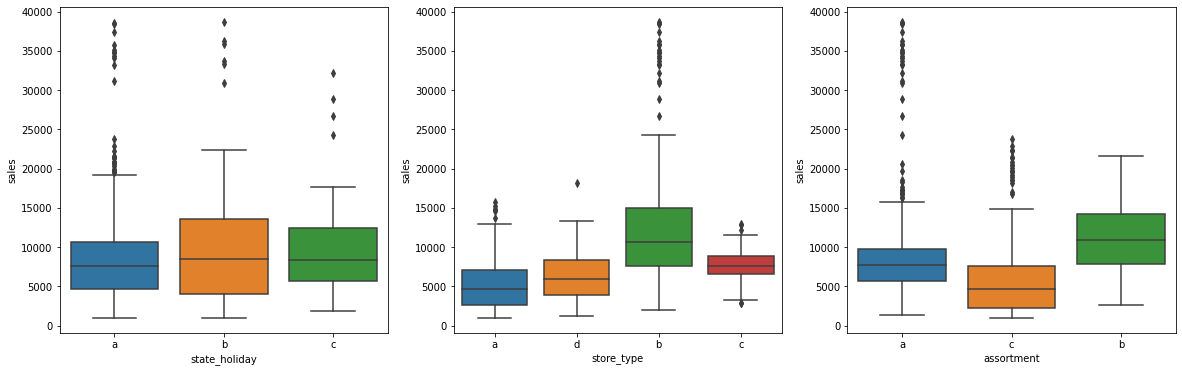

In [23]:
plt.figure(figsize=(20, 6))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

#plt.subplot(2, 2, 1)
#sns.boxplot(x='promo_interval', y='sales', data=aux1)

#plt.subplot(2, 2, 2)
#sns.boxplot(x='month_map', y='sales', data=aux1)


# 2.0. FEATURE ENGINEERING

In [41]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

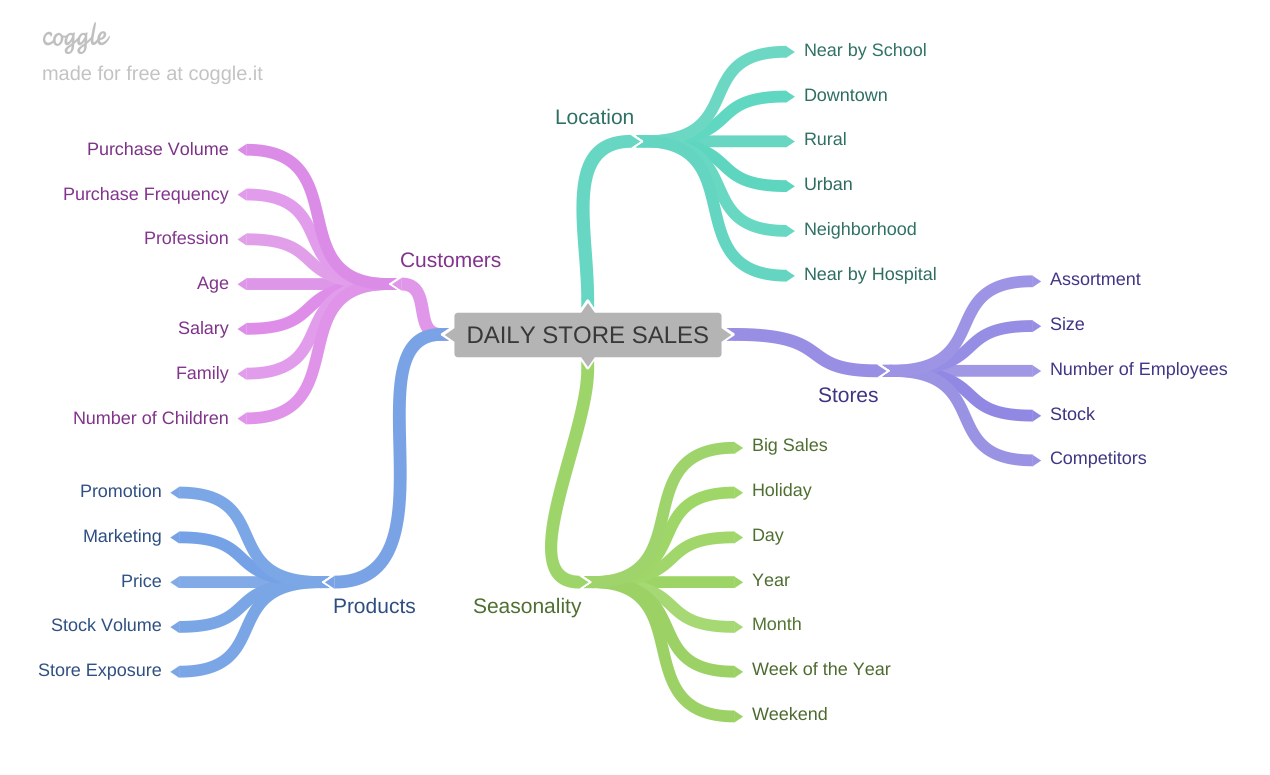

In [25]:
Image('../img/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Store with more employees should sell more

**2.** Store with big stock should sell more

**3.** Big store should sell more

**4.** Small store should sell less

**5.** Store with big assortment should sell more

**6.** Store with close competitors should sell less

**7.** Store with competitors for a long time should sell more

### 2.2.2. Product Hypothesis

**1.** Store that more invest in marketing should sell more

**2.** Store that more exposes its products in the showcase should sell more

**3.** Store that has small prices should sell more

**4.** Store that has small prices for a long period should sell more

**5.** Store with active promotion for a long time should sell more

**6.** Store with more days in promotion should sell more

**7.** Store with consecutive promotion should sell more

### 2.2.3. Time Hypothesis

**1.** Store in places with more holidays should sell less

**2.** Store that opens in the first 6 months of the year should sell more

**3.** Store opened during Christmas should sell more

**4.** Store should sell more through the years

**5.** Store should sell more in the second semester of the year

**6.** Store should sell more after the 10th day of each month

**7.** Store should sell less on weekends

**8.** Store should sell less during the school holidays

## 2.3. Final List of Hypothesis

**1.** Store with big assortment should sell more

**2.** Store with close competitors should sell less

**3.** Store with competitors for a long time should sell more

**4.** Store with active promotion for a long time should sell more

**5.** Store with more days in promotion should sell more

**6.** Store with consecutive promotion should sell more

**7.** Store opened during Christmas should sell more

**8.** Store should sell more through the years

**9.** Store should sell more in the second semester of the year

**10.** Store should sell more after the 10th day of each month

**11.** Store should sell less on weekends

**12.** Store should sell less during the school holidays

## 2.4. Feature Engineering

In [42]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                month=x['competition_open_since_month'],
                                day=1),
    axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /
                                 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'
                                         ) - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /
                          7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday'
    if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [43]:
df2.sample(9).T

,354601,877893,511283,848643,421635,450694,940705,614399,66104
store,488,59,284,914,951,1020,431,820,320
day_of_week,3,7,7,6,4,6,7,6,2
date,2014-08-27 00:00:00,2013-05-05 00:00:00,2014-03-30 00:00:00,2013-06-01 00:00:00,2014-06-19 00:00:00,2014-05-24 00:00:00,2013-03-10 00:00:00,2013-12-28 00:00:00,2015-06-02 00:00:00
sales,3072,0,0,7188,0,9614,0,12285,17554
customers,383,0,0,852,0,1168,0,1097,2261
open,1,0,0,1,0,1,0,1,1
promo,0,0,0,0,1,0,0,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day,public_holiday,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0,0,0,0,0
store_type,a,a,d,c,d,a,d,a,a


# 3.0. FILTERING OF VARIABLES

In [44]:
df3 = df2.copy()

## 3.1. Filteting Lines

In [45]:
df3 = df3[(df3['open'] != 0) & (df['sales'] > 0)]

## 3.2. Filtering Columns

In [46]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [49]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0
